In [1]:
import os, sys, time, copy
import numpy as np
import matplotlib.pyplot as plt

import myokit
sys.path.append('../')
sys.path.append('../Protocols')
sys.path.append('../Models')
sys.path.append('../Lib')
import protocol_lib, vc_protocols
import mod_trace
from kylie2017IKr import Kylie2017IKr

C:\Anaconda3\envs\ml\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Anaconda3\envs\ml\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
C:\Anaconda3\envs\ml\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:\n%s" %


Kylie dataset has been selected.
(9, 2)


In [2]:
# V = model.voltage(times)
g = 0.1524 * 1e3 # [pA/V]
p1 = 2.26e-4 * 1e3 # [1/s]
p2 = 0.0699 * 1e3  # [1/V]
p3 = 3.45e-5 * 1e3 # [1/s]
p4 = 0.05462 * 1e3 # [1/V]
p5 = 0.0873 * 1e3  # [1/s]
p6 = 8.91e-3 * 1e3 # [1/V]
p7 = 5.15e-3 * 1e3 # [1/s]
p8 = 0.03158 * 1e3 # [1/V]

dt = 0.0002
t_eval = np.arange(77000)*dt  # times = np.linspace(0, 15.4, 77000)
t_span = (0, t_eval.max())

In [3]:
import simulator_myokit
import vc_protocols_for_myokit
'''
Simulation with Myokit
'''
model_path = "../mmt-model-files/kylie-2017-IKr.mmt" 
model, protocol, script = myokit.load(model_path)
protocol = vc_protocols.leak_staircase()

# model, protocol, _ = vc_protocols_for_myokit.leak_staircase(model)
sim_myokit = simulator_myokit.Simulator(model, protocol, max_step=None, abs_tol=1e-08, rel_tol=1e-10, vhold=-80e-3 )  # 1e-12, 1e-14  # 1e-08, 1e-10
sim_myokit.name = "kylie-2017-IKr"

In [4]:
start_time = time.time()

y0 = sim_myokit.pre_simulate( 100, sim_type=1)
d_myokit = sim_myokit.simulate(t_eval.max()+dt, log_times=t_eval, extra_log=['ikr.IKr', 'ikr.open', 'ikr.active'])
population_by_continent = {
    'O': d_myokit['ikr.open']*d_myokit['ikr.active'],
    'I': d_myokit['ikr.open']*(1-d_myokit['ikr.active']),
    'C': (1-d_myokit['ikr.open'])*d_myokit['ikr.active'],
    'IC': (1-d_myokit['ikr.open'])*(1-d_myokit['ikr.active']),    
}
print("--- %s seconds ---"%(time.time()-start_time))

--- 0.7495927810668945 seconds ---


In [5]:
y0

[0.0003089493160114065, 0.6008111994422601]

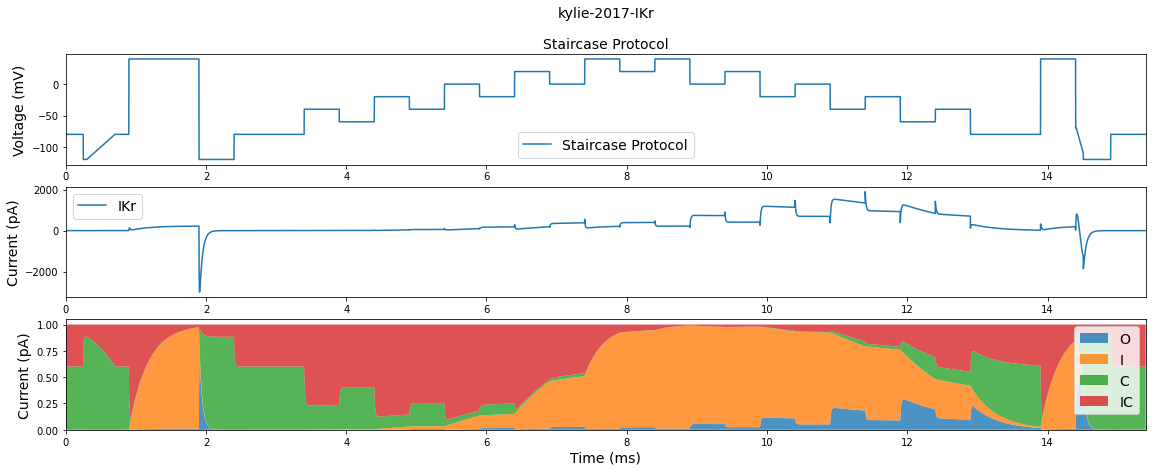

Complete


In [6]:
fig, axes = plt.subplots(3, figsize=(15, 6))
fig.suptitle(sim_myokit.name, fontsize=14)
axes[0].set_title("Staircase Protocol", fontsize=14)
axes[0].set_xlim(0, t_eval[-1])
axes[0].set_ylabel("Voltage (mV)", fontsize=14)
axes[0].plot( t_eval, d_myokit['membrane.V']*1000, label="Staircase Protocol")
# textstr = "GNa : %1.4f\nGNaL : %1.4f\nGto : %1.4f\nPCa : %1.4f\nGKr : %1.4f\nGKs : %1.4f\nGK1 : %1.4f\nGf : %1.4f"%(Gs[0], Gs[1], Gs[2], Gs[3], Gs[4], Gs[5], Gs[6], Gs[7])
# props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
# axes[0].text(0.67, 0.60, textstr, transform=axs[0].transAxes, fontsize=14, verticalalignment='top', bbox=props)    
axes[0].legend(fontsize=14)
axes[0].xaxis.set_visible(True)

axes[1].set_xlim(0, t_eval[-1])
axes[1].set_ylabel("Current (pA)", fontsize=14)
axes[1].plot(t_eval, d_myokit['ikr.IKr']*1000, label="IKr")
axes[1].legend(fontsize=14)
axes[1].xaxis.set_visible(True)

axes[2].set_xlim(0, t_eval[-1])
axes[2].set_xlabel("Time (ms)", fontsize=14)
axes[2].set_ylabel("Current (pA)", fontsize=14)
axes[2].stackplot(t_eval, population_by_continent.values(), labels=population_by_continent.keys(), alpha=0.8)
axes[2].legend(fontsize=14)
axes[2].xaxis.set_visible(True)

plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=0.87, wspace=0.5, hspace=0.2)
# fig.tight_layout()#rect=[0.5, 0.5, 0.5, 0.5]
plt.show()
fig.savefig(os.path.join('Results', 'Kylie2017IKr-StaircaseVC'), dpi=100)
print("Complete")

In [7]:
import simulator_scipy
'''
Simulation with solve_ivp
'''
protocol = vc_protocols.leak_staircase()
model = Kylie2017IKr(protocol)
simulator = simulator_scipy.Simulator(model)

In [8]:
start_time = time.time()

simulator.model.set_params(g, p1, p2, p3, p4, p5, p6, p7, p8)
model.y0 = y0
# y0 = simulator.pre_simulate( pre_step=100, protocol='constant' )        
solution = simulator.simulate(t_span=t_span, t_eval=t_eval, method='LSODA', max_step=8e-4, atol=1e-08, rtol=1e-10) # 1e-12, 1e-14  # 1e-08, 1e-10
  
population_by_continent = {
    'O': model.open*model.active,
    'I': model.open*(1-model.active),
    'C': (1-model.open)*model.active,
    'IC': (1-model.open)*(1-model.active),    
}
print("--- %s seconds ---"%(time.time()-start_time))

--- 2.4885642528533936 seconds ---


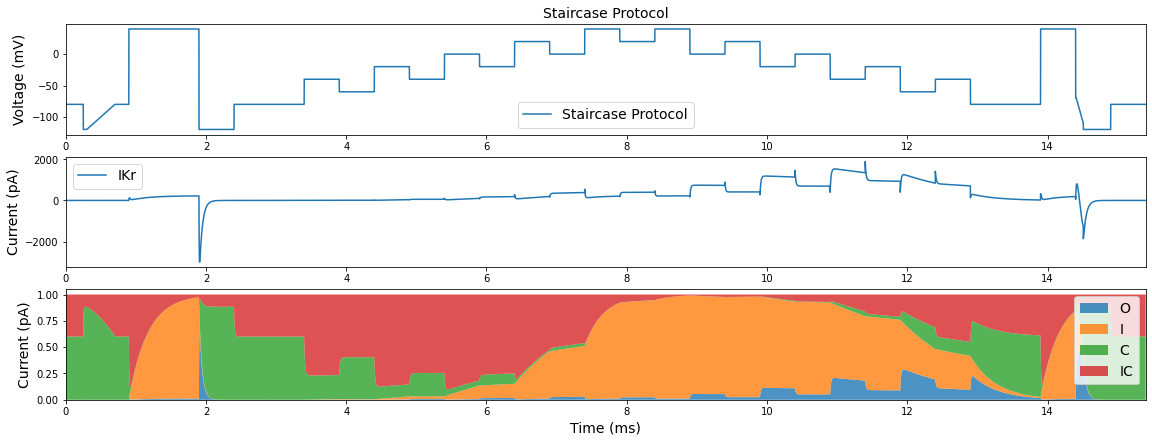

Complete


In [9]:
fig, axes = plt.subplots(3, figsize=(15, 6))
fig.suptitle(simulator.name, fontsize=14)
axes[0].set_title("Staircase Protocol", fontsize=14)
axes[0].set_xlim(0, model.times[-1])
axes[0].set_ylabel("Voltage (mV)", fontsize=14)
axes[0].plot( model.times, model.V*1000, label="Staircase Protocol")
axes[0].legend(fontsize=14)
axes[0].xaxis.set_visible(True)

axes[1].set_xlim(0, model.times[-1])
axes[1].set_ylabel("Current (pA)", fontsize=14)
axes[1].plot(model.times, model.IKr*1000, label="IKr")
axes[1].legend(fontsize=14)
axes[1].xaxis.set_visible(True)

axes[2].set_xlim(0, model.times[-1])
axes[2].set_xlabel("Time (ms)", fontsize=14)
axes[2].set_ylabel("Current (pA)", fontsize=14)
axes[2].stackplot(model.times, population_by_continent.values(), labels=population_by_continent.keys(), alpha=0.8)
axes[2].legend(fontsize=14)
axes[2].xaxis.set_visible(True)

plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=0.87, wspace=0.5, hspace=0.2)
# fig.tight_layout()#rect=[0.5, 0.5, 0.5, 0.5]
plt.show()
fig.savefig(os.path.join('Results', 'Kylie2017IKr-StaircaseVC'), dpi=100)
print("Complete")

In [10]:
import simulator_euler
protocol = vc_protocols.leak_staircase()
model = Kylie2017IKr(protocol)
simulator = simulator_euler.Simulator(model)

In [11]:
start_time = time.time()
simulator.model.set_params(g, p1, p2, p3, p4, p5, p6, p7, p8)
simulator.dt = 0.001
model.y0 = y0
simulator.simulate(end_time=15.4)  
population_by_continent = {
    'O': model.open*model.active,
    'I': model.open*(1-model.active),
    'C': (1-model.open)*model.active,
    'IC': (1-model.open)*(1-model.active),    
}
print("--- %s seconds ---"%(time.time()-start_time))

--- 0.4072728157043457 seconds ---


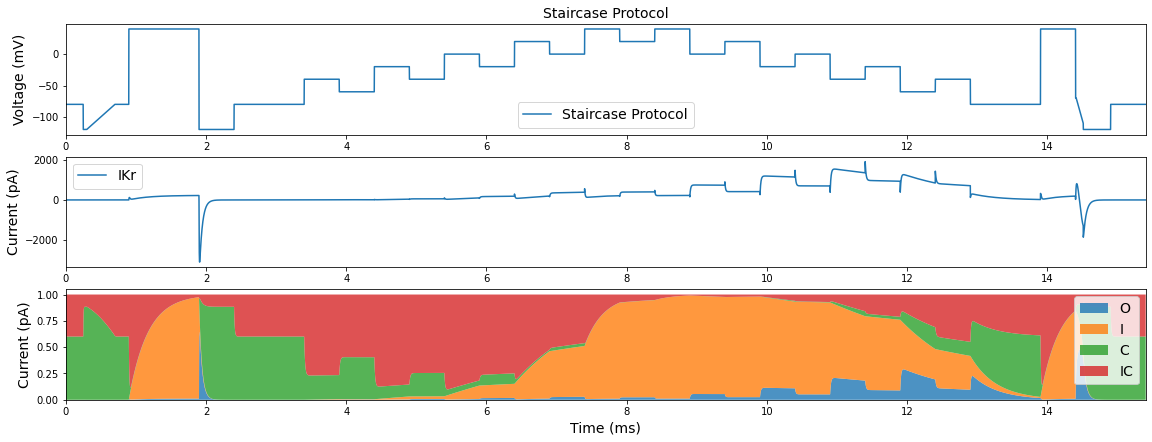

Complete


In [12]:
fig, axes = plt.subplots(3, figsize=(15, 6))
fig.suptitle(simulator.name, fontsize=14)
axes[0].set_title("Staircase Protocol", fontsize=14)
axes[0].set_xlim(0, model.times[-1])
axes[0].set_ylabel("Voltage (mV)", fontsize=14)
axes[0].plot( model.times, model.V*1000, label="Staircase Protocol")
# textstr = "GNa : %1.4f\nGNaL : %1.4f\nGto : %1.4f\nPCa : %1.4f\nGKr : %1.4f\nGKs : %1.4f\nGK1 : %1.4f\nGf : %1.4f"%(Gs[0], Gs[1], Gs[2], Gs[3], Gs[4], Gs[5], Gs[6], Gs[7])
# props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
# axes[0].text(0.67, 0.60, textstr, transform=axs[0].transAxes, fontsize=14, verticalalignment='top', bbox=props)    
axes[0].legend(fontsize=14)
axes[0].xaxis.set_visible(True)

axes[1].set_xlim(0, model.times[-1])
axes[1].set_ylabel("Current (pA)", fontsize=14)
axes[1].plot(model.times, model.IKr*1000, label="IKr")
axes[1].legend(fontsize=14)
axes[1].xaxis.set_visible(True)

axes[2].set_xlim(0, model.times[-1])
axes[2].set_xlabel("Time (ms)", fontsize=14)
axes[2].set_ylabel("Current (pA)", fontsize=14)
axes[2].stackplot(model.times, population_by_continent.values(), labels=population_by_continent.keys(), alpha=0.8)
axes[2].legend(fontsize=14)
axes[2].xaxis.set_visible(True)

plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=0.87, wspace=0.5, hspace=0.2)
# fig.tight_layout()#rect=[0.5, 0.5, 0.5, 0.5]
plt.show()
fig.savefig(os.path.join('Results', 'Kylie2017IKr-StaircaseVC'), dpi=100)
print("Complete")

In [13]:
# VC_protocol = jk_protocols.VoltageClampProtocol()  # steps=steps
# tpre  = 0.2           # Time before step to variable V
# tstep = 0.5           # Time at variable V
# tpost = 0.1           # Time after step to variable V
# vhold = -80e-3
# vmin = -60e-3#-100e-3
# vmax = 40e-3
# vres = 20e-3        # Difference in V between steps
# v = np.arange(vmin, vmax + vres, vres)
# # Leak estimate
# VC_protocol.add( jk_protocols.VoltageClampStep(voltage=vhold, duration=0.25) )
# VC_protocol.add( jk_protocols.VoltageClampStep(voltage=-120e-3, duration=0.05) )
# VC_protocol.add( jk_protocols.VoltageClampRamp(voltage_start=-0.12, voltage_end=-0.08, duration=0.4)) # ramp step
# # Staircase
# VC_protocol.add( jk_protocols.VoltageClampStep(voltage=vhold, duration=0.2) )
# VC_protocol.add( jk_protocols.VoltageClampStep(voltage=40e-3, duration=1.0) )
# VC_protocol.add( jk_protocols.VoltageClampStep(voltage=-120e-3, duration=0.5) )
# VC_protocol.add( jk_protocols.VoltageClampStep(voltage=vhold, duration=1.0) )
# for vstep in v[1::]:
#     VC_protocol.add( jk_protocols.VoltageClampStep(voltage=vstep, duration=tstep) )
#     VC_protocol.add( jk_protocols.VoltageClampStep(voltage=vstep-vres, duration=tstep) )    
# for vstep in v[::-1][:-1]:
#     VC_protocol.add( jk_protocols.VoltageClampStep(voltage=vstep, duration=tstep) )
#     VC_protocol.add( jk_protocols.VoltageClampStep(voltage=vstep-2*vres, duration=tstep) )    
# VC_protocol.add( jk_protocols.VoltageClampStep(voltage=vhold, duration=1.0 - tstep) )    # extend a bit the ending...
# # EK estimate
# VC_protocol.add( jk_protocols.VoltageClampStep(voltage=40e-3, duration=tstep) )
# VC_protocol.add( jk_protocols.VoltageClampStep(voltage=-70e-3, duration=10e-3) )  # Michael's suggestion
# VC_protocol.add( jk_protocols.VoltageClampRamp(voltage_start=-70e-3, voltage_end=-110e-3, duration=0.1))  # second ramp step  
# VC_protocol.add( jk_protocols.VoltageClampStep(voltage=-120e-3, duration=tstep-10e-3-10e-3) ) # ???
# VC_protocol.add( jk_protocols.VoltageClampStep(voltage=vhold, duration=100) )

# duration = VC_protocol.get_voltage_change_endpoints()[-1]
# times = np.arange(0, 15.4, 0.001)
# VC_protocol.plot_voltage_clamp_protocol(times, unit='s')
# voltages = VC_protocol.get_voltage_clamp_protocol(times)
# print(VC_protocol)